# Calculate anomalies

## Calculates climate anomalies based on time priod average

- visualizes full time series of raw data
- calculates anomalies
- visualizes clipped time series of raw data
- visualizes clipped time series of anomaly data

## Setup

<xarray.Dataset> Size: 77MB
Dimensions:      (time: 228, lat: 71, lon: 74)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 284B -9.825 -9.875 -9.925 ... -13.28 -13.33
  * lon          (lon) float32 296B -72.38 -72.32 -72.28 ... -68.78 -68.72
    spatial_ref  int64 8B ...
Data variables:
    tmmx         (time, lat, lon) float64 10MB ...
    tmmn         (time, lat, lon) float64 10MB ...
    pr           (time, lat, lon) float64 10MB ...
    pdsi         (time, lat, lon) float64 10MB ...
    def          (time, lat, lon) float64 10MB ...
    vpd          (time, lat, lon) float64 10MB ...
    soil         (time, lat, lon) float64 10MB ...
    lai          (time, lat, lon) float64 10MB ...
EPSG:4326
('time', 'lat', 'lon')


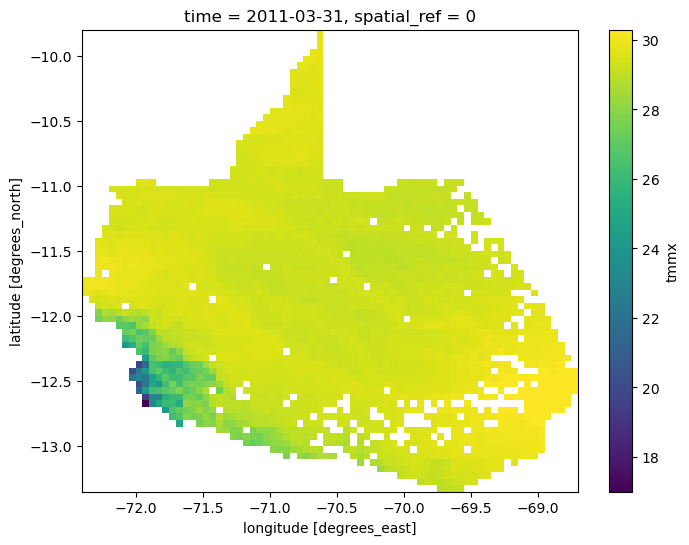

In [49]:
# import packages
import xarray as xr
import rioxarray as rio
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import glob
import rasterio
import re
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from rasterio.enums import Resampling 
import matplotlib.dates as mdates

# load in data
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# climate + LAI netCDF
# --------------------------

# load data set
combo_xr = xr.open_dataset("/home/jovyan/large_files/climLai_masked_v3.nc")

# set a crs (somehow it loses this when you export as a netCDF)
if combo_xr.rio.crs is None:
    combo_xr = combo_xr.rio.write_crs("EPSG:4326")

# print some info
print(combo_xr)
print(combo_xr['lai'].rio.crs)
print(combo_xr['lai'].dims)
# print(combo_xr.time.values)

# plot
combo_xr.tmmx.isel(time=110).plot(figsize=(8,6))


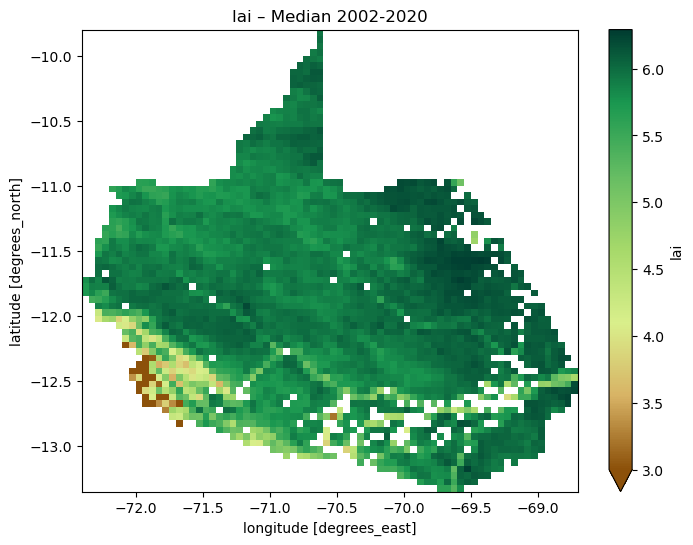

In [50]:
# Pick the band
var_name = list(combo_xr.data_vars)[7]

# Median over time
median_map = combo_xr[var_name].median(dim="time")

# Your colors → continuous gradient
# my_colors = [
#     "#08306b",  # darker blue (new)
#     "#2c7bb6",  # blue
#     "#abd9e9",  # light blue
#     "#ffffbf",  # yellow
#     "#fdae61",  # orange
#     "#d7191c",  # red
#     "#67000d"   # darker red (new)
# ]

my_colors = [
    "#8c510a",  # dark brown (very low LAI / bare)
    "#d8b365",  # light brown
    "#d9ef8b",  # yellow-green (replaced pale yellow)
    "#a6d96a",  # light green (replaced very light green)
    "#66bd63",  # medium green
    "#1a9850",  # dark green
    "#003c30"   # very dark green (dense canopy)
]

custom_cmap = LinearSegmentedColormap.from_list("custom_continuous", my_colors)

# Plot
plt.figure(figsize=(8,6))
median_map.plot(cmap=custom_cmap,#.reversed(),
               vmin=3, #0, #-2, #0,     
               #  vmax=6.5 #10 #2 #35
               )      
plt.title(f"{var_name} – Median 2002-2020")
plt.show()

In [51]:
pretty_names = {
    "tmmx": "Max Temperature (°C)",
    "tmmn": "Min Temperature (°C)",
    "pr":   "Precipitation (mm)",
    "pdsi": "PDSI",
    "def":  "Water Deficit (mm)",
    "vpd":  "VPD (kPa)",
    "soil": "Soil Moisture (mm)",
    "lai":  "LAI (m2/m2)"
}

## Visualize Full Time Series

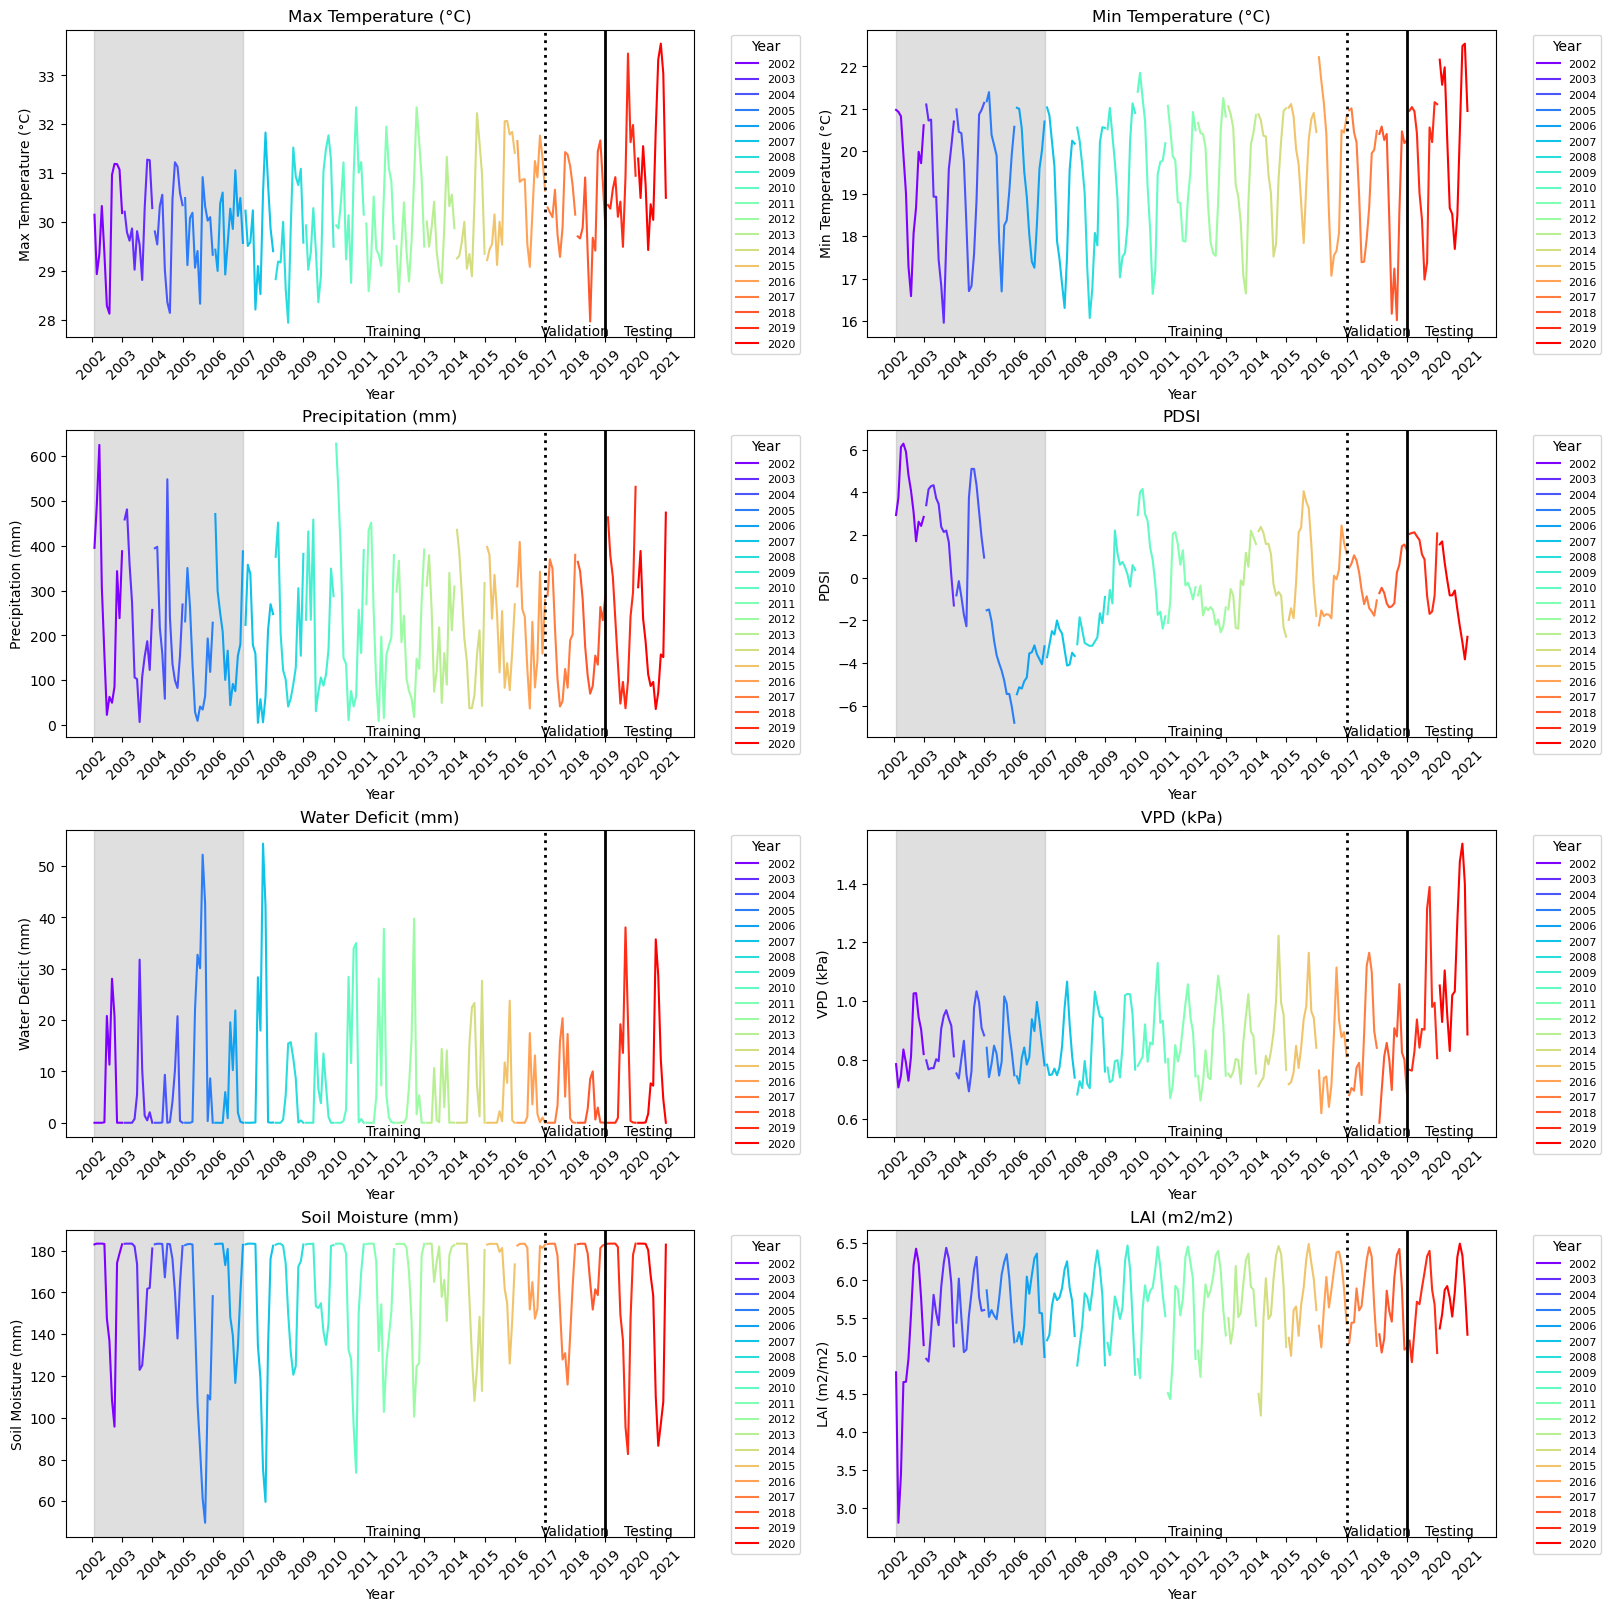

In [58]:
# Compute spatial mean
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# ---- Train / Val / Test split dates ----
val_split  = np.datetime64("2017-01-01")
test_split = np.datetime64("2019-01-01")
shade_end  = np.datetime64("2007-01-01")

# ---- MANUAL label x-positions (EDIT THESE) ----
train_x = np.datetime64("2012-01-01")
val_x   = np.datetime64("2018-01-01")
test_x  = np.datetime64("2020-06-01")

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, nrows * 4),
    constrained_layout=True
)
axes = axes.flatten()

for idx, var in enumerate(spatialMean_xr.data_vars):
    ax = axes[idx]

    years = np.unique(spatialMean_xr[var].time.dt.year.values)
    colors = cm.rainbow(np.linspace(0, 1, len(years)))

    # ---- Grey shading before Jan 2007 ----
    ax.axvspan(
        spatialMean_xr.time.min().values,
        shade_end,
        color="grey",
        alpha=0.25,
        zorder=0
    )

    for i, (year, group) in enumerate(spatialMean_xr[var].groupby("year")):
        group.plot(ax=ax, label=str(year), color=colors[i], zorder=2)

    pretty = pretty_names.get(var, var)
    ax.set_title(pretty)
    ax.set_ylabel(pretty)
    ax.set_xlabel("Year")

    # ---- Force yearly ticks ----
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45)

    # ---- Vertical split lines ----
    ax.axvline(val_split,  color="black", linestyle=":", linewidth=2)
    ax.axvline(test_split, color="black", linestyle="-", linewidth=2)

    # ---- Manual label placement ----
    y0, y1 = ax.get_ylim()
    y_pos = y0 + 0.04 * (y1 - y0)

    ax.text(train_x, y_pos, "Training",
            ha="center", va="top", fontsize=10)

    ax.text(val_x, y_pos, "Validation",
            ha="center", va="top", fontsize=10)

    ax.text(test_x, y_pos, "Testing",
            ha="center", va="top", fontsize=10)

    # Legend outside
    ax.legend(
        title="Year",
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

# Remove empty subplots
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.show()


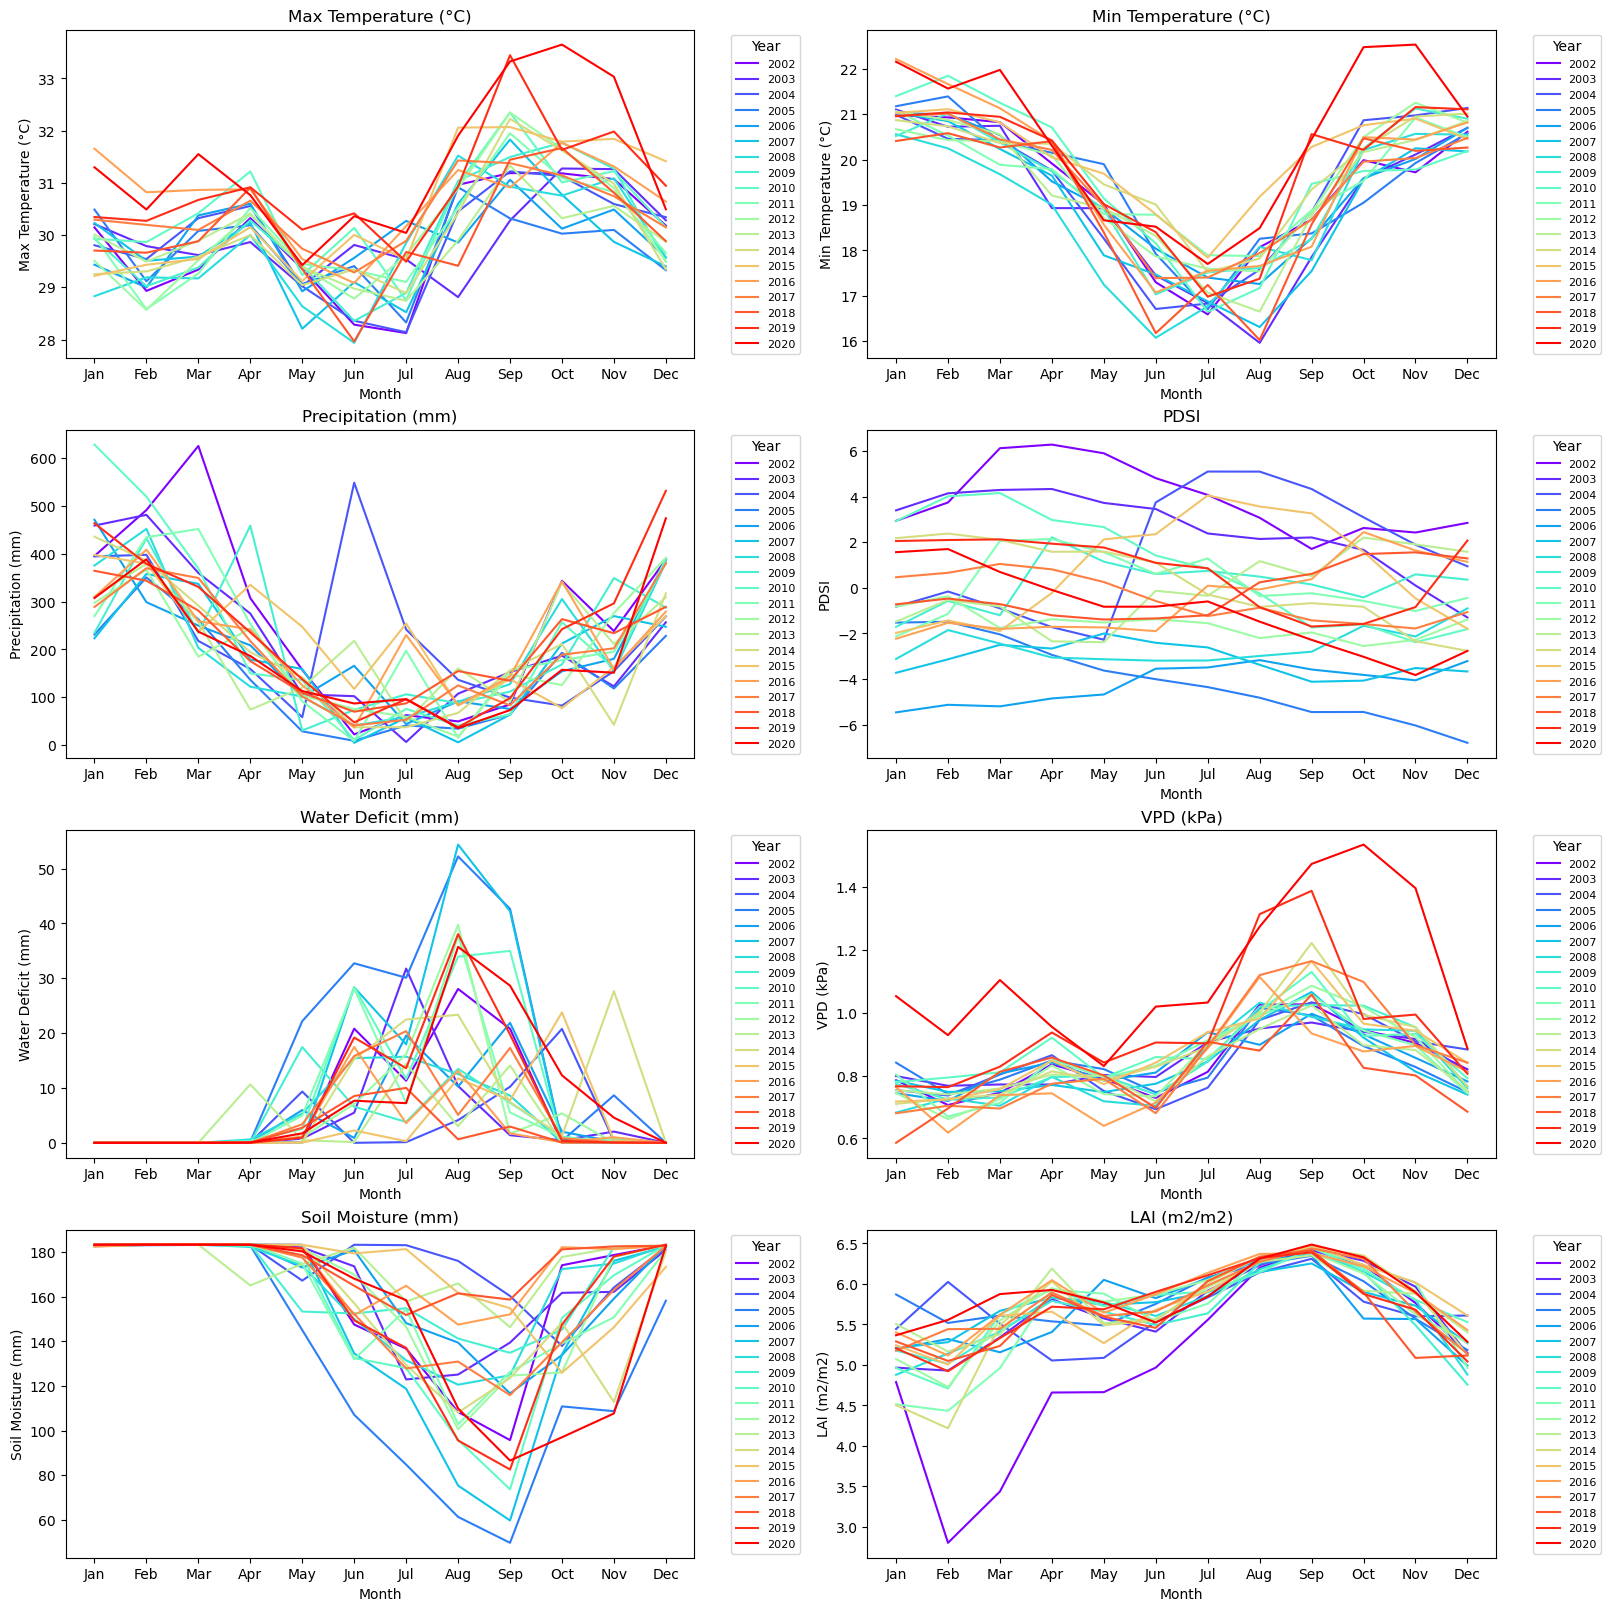

In [59]:
# Compute spatial mean
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, nrows * 4),
    constrained_layout=True
)
axes = axes.flatten()

for idx, var in enumerate(spatialMean_xr.data_vars):
    ax = axes[idx]

    years = np.unique(spatialMean_xr[var].year.values)
    colors = cm.rainbow(np.linspace(0, 1, len(years)))

    # ---- Plot each year as Jan–Dec on same axis ----
    for i, year in enumerate(years):
        yearly = spatialMean_xr[var].sel(time=spatialMean_xr.year == year)
        monthly = yearly.groupby("month").mean()

        ax.plot(
            monthly["month"],
            monthly.values,
            color=colors[i],
            label=str(year)
        )

    pretty = pretty_names.get(var, var)
    ax.set_title(pretty)
    ax.set_ylabel(pretty)
    ax.set_xlabel("Month")

    # ---- Month ticks & labels ----
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(
        ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
         "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    )

    # Legend outside (unchanged)
    ax.legend(
        title="Year",
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

# Remove empty subplots
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.show()


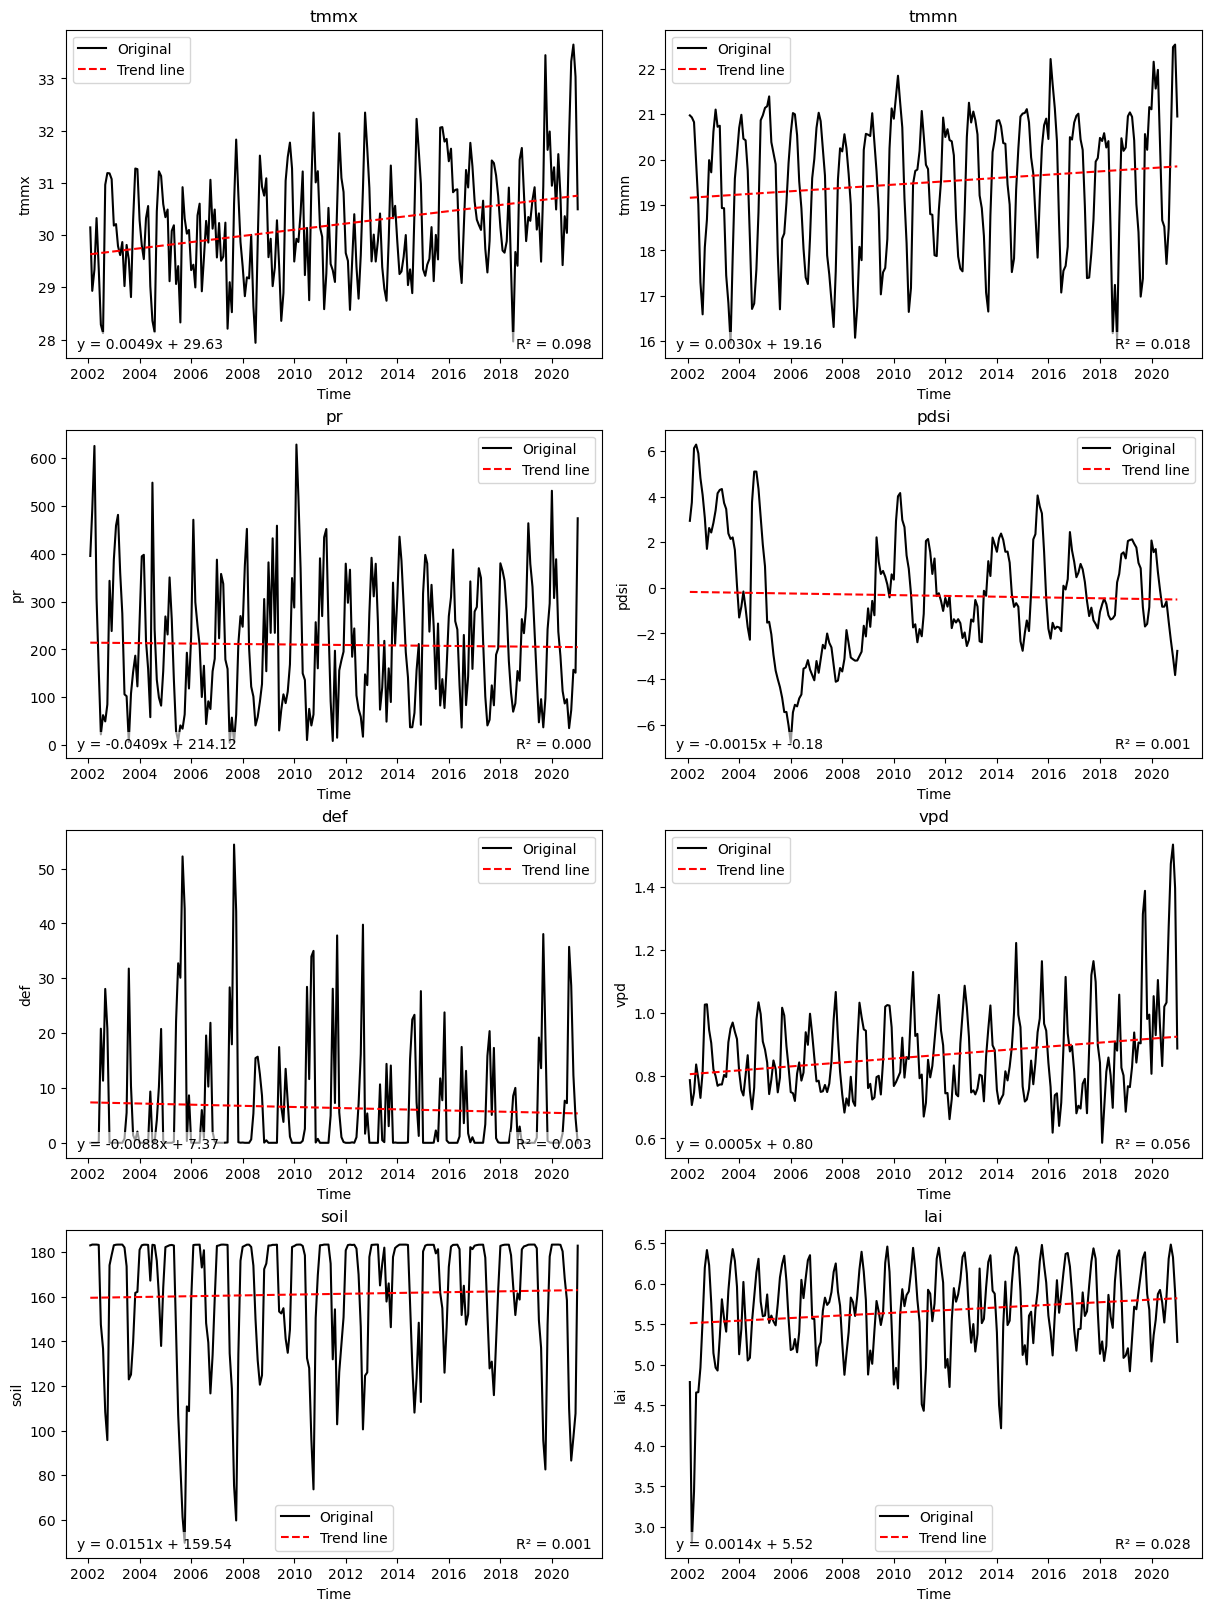

In [42]:
# Take spatial mean so we get 1D time series
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

num_vars = len(spatialMean_xr.data_vars)
ncols = 2  # adjust number of columns for tiling
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows*4), constrained_layout=True)
axes = axes.flatten()  # flatten in case of more than 1 row/col

for i, var in enumerate(spatialMean_xr.data_vars):
    y = spatialMean_xr[var].values
    x = np.arange(len(y))  # simple index for time axis

    # Fit linear trend
    coeffs = np.polyfit(x, y, 1)
    trend = np.polyval(coeffs, x)

    # Calculate R^2
    correlation_matrix = np.corrcoef(y, trend)
    r_squared = correlation_matrix[0, 1]**2

    # Plot
    axes[i].plot(spatialMean_xr.time.values, y, color="black", label="Original")
    axes[i].plot(spatialMean_xr.time.values, trend, color="red", linestyle="--", label="Trend line")

    # Add equation box (lower left)
    eq_text = f"y = {coeffs[0]:.4f}x + {coeffs[1]:.2f}"
    axes[i].text(0.02, 0.02, eq_text, transform=axes[i].transAxes,
                 fontsize=10, verticalalignment='bottom', horizontalalignment='left',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Add R² box (lower right)
    r2_text = f"R² = {r_squared:.3f}"
    axes[i].text(0.98, 0.02, r2_text, transform=axes[i].transAxes,
                 fontsize=10, verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    axes[i].set_title(var)
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel(var)
    axes[i].legend()

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# # Save as one PNG
# plt.savefig("/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varRaw_timeSeriesFull_wTrend_clip0720.png", dpi=300, bbox_inches='tight')
plt.show()

## Clipp time seriesed

In [62]:
combo_xr = combo_xr.sel(time=slice("2007-01-01", "2020-12-31"))
print(combo_xr)

<xarray.Dataset> Size: 56MB
Dimensions:      (time: 168, lat: 71, lon: 74)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2007-01-31 2007-02-28 ... 2020-12-31
  * lat          (lat) float32 284B -9.825 -9.875 -9.925 ... -13.28 -13.33
  * lon          (lon) float32 296B -72.38 -72.32 -72.28 ... -68.78 -68.72
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 7MB nan nan nan nan ... nan nan nan
    tmmn         (time, lat, lon) float64 7MB nan nan nan nan ... nan nan nan
    pr           (time, lat, lon) float64 7MB nan nan nan nan ... nan nan nan
    pdsi         (time, lat, lon) float64 7MB nan nan nan nan ... nan nan nan
    def          (time, lat, lon) float64 7MB nan nan nan nan ... nan nan nan
    vpd          (time, lat, lon) float64 7MB nan nan nan nan ... nan nan nan
    soil         (time, lat, lon) float64 7MB nan nan nan nan ... nan nan nan
    lai          (time, lat, lon) float64 7MB nan nan nan nan ... nan nan nan


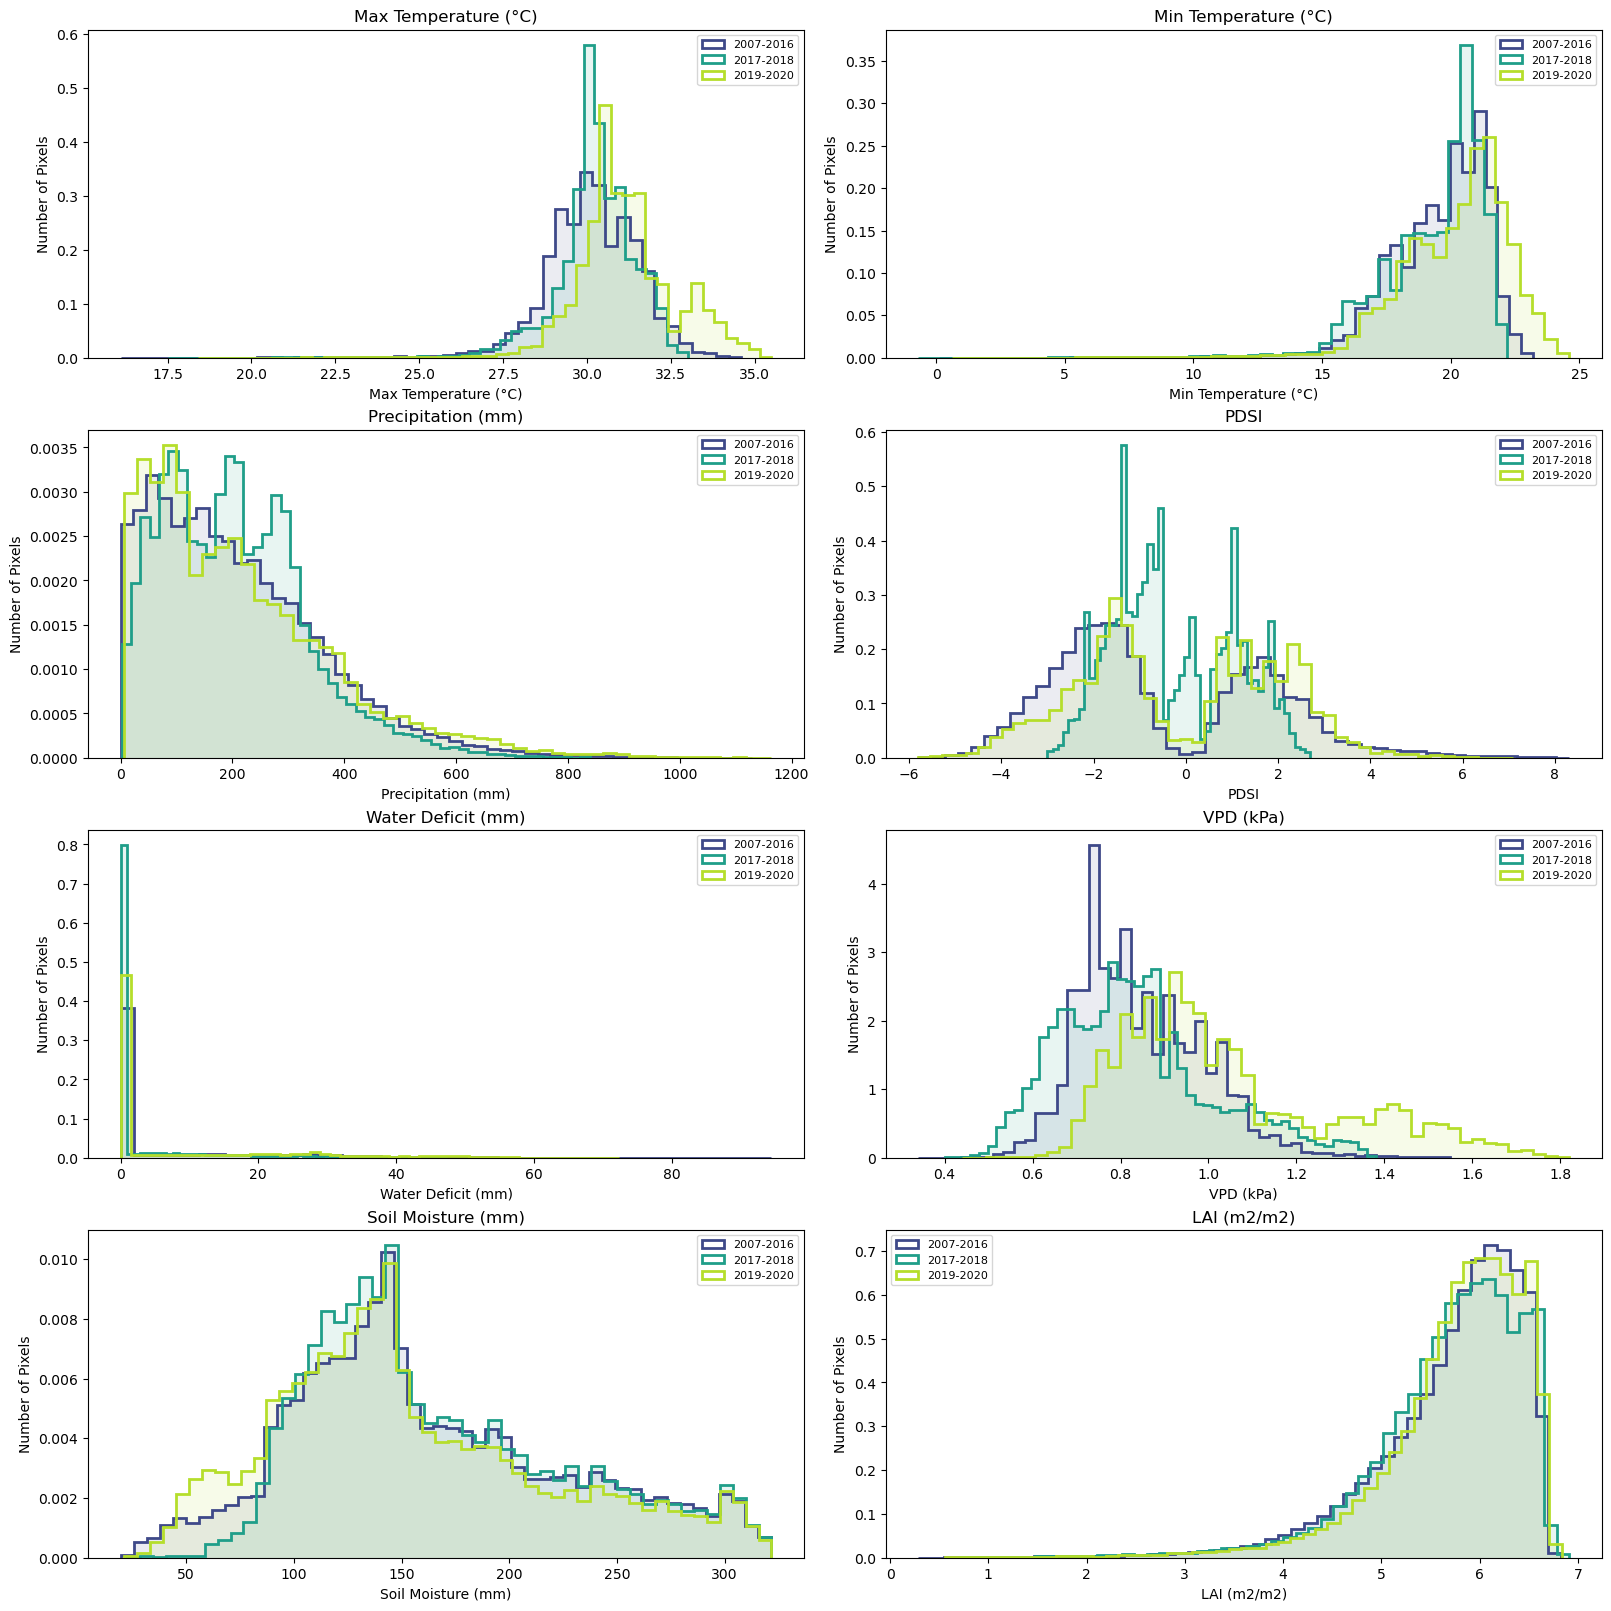

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Define your time slices ----
slices = {
    "2007-2016": slice("2007-01-01", "2016-12-31"),
    "2017-2018": slice("2017-01-01", "2018-12-31"),
    "2019-2020": slice("2019-01-01", "2020-12-31"),
}
colors = ["#3e4989", "#1f9e89", "#b5de2b"]  # hex colors
alpha_fill = 0.1  # very light fill
linewidth = 2     # outline thickness

# Determine grid layout
num_vars = len(combo_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, nrows * 4),
    constrained_layout=True
)
axes = axes.flatten()

for idx, var in enumerate(combo_xr.data_vars):
    ax = axes[idx]
    
    for color, (label, time_slice) in zip(colors, slices.items()):
        # select the time slice and flatten to 1D
        data_slice = combo_xr[var].sel(time=time_slice).values.flatten()
        data_slice = data_slice[~np.isnan(data_slice)]
        
        # Draw filled histogram first (very light)
        ax.hist(
            data_slice,
            bins=50,
            color=color,
            alpha=alpha_fill,
            density=True,
            histtype='stepfilled',
            linewidth=0
        )
        
        # Draw outline on top
        ax.hist(
            data_slice,
            bins=50,
            color=color,
            density=True,
            histtype='step',
            linewidth=linewidth,
            label=label
        )

    pretty = pretty_names.get(var, var)
    ax.set_title(pretty)
    ax.set_xlabel(pretty)        # <-- use pretty name here
    ax.set_ylabel("Number of Pixels")
    ax.legend(fontsize=8)

# Remove empty subplots
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.show()


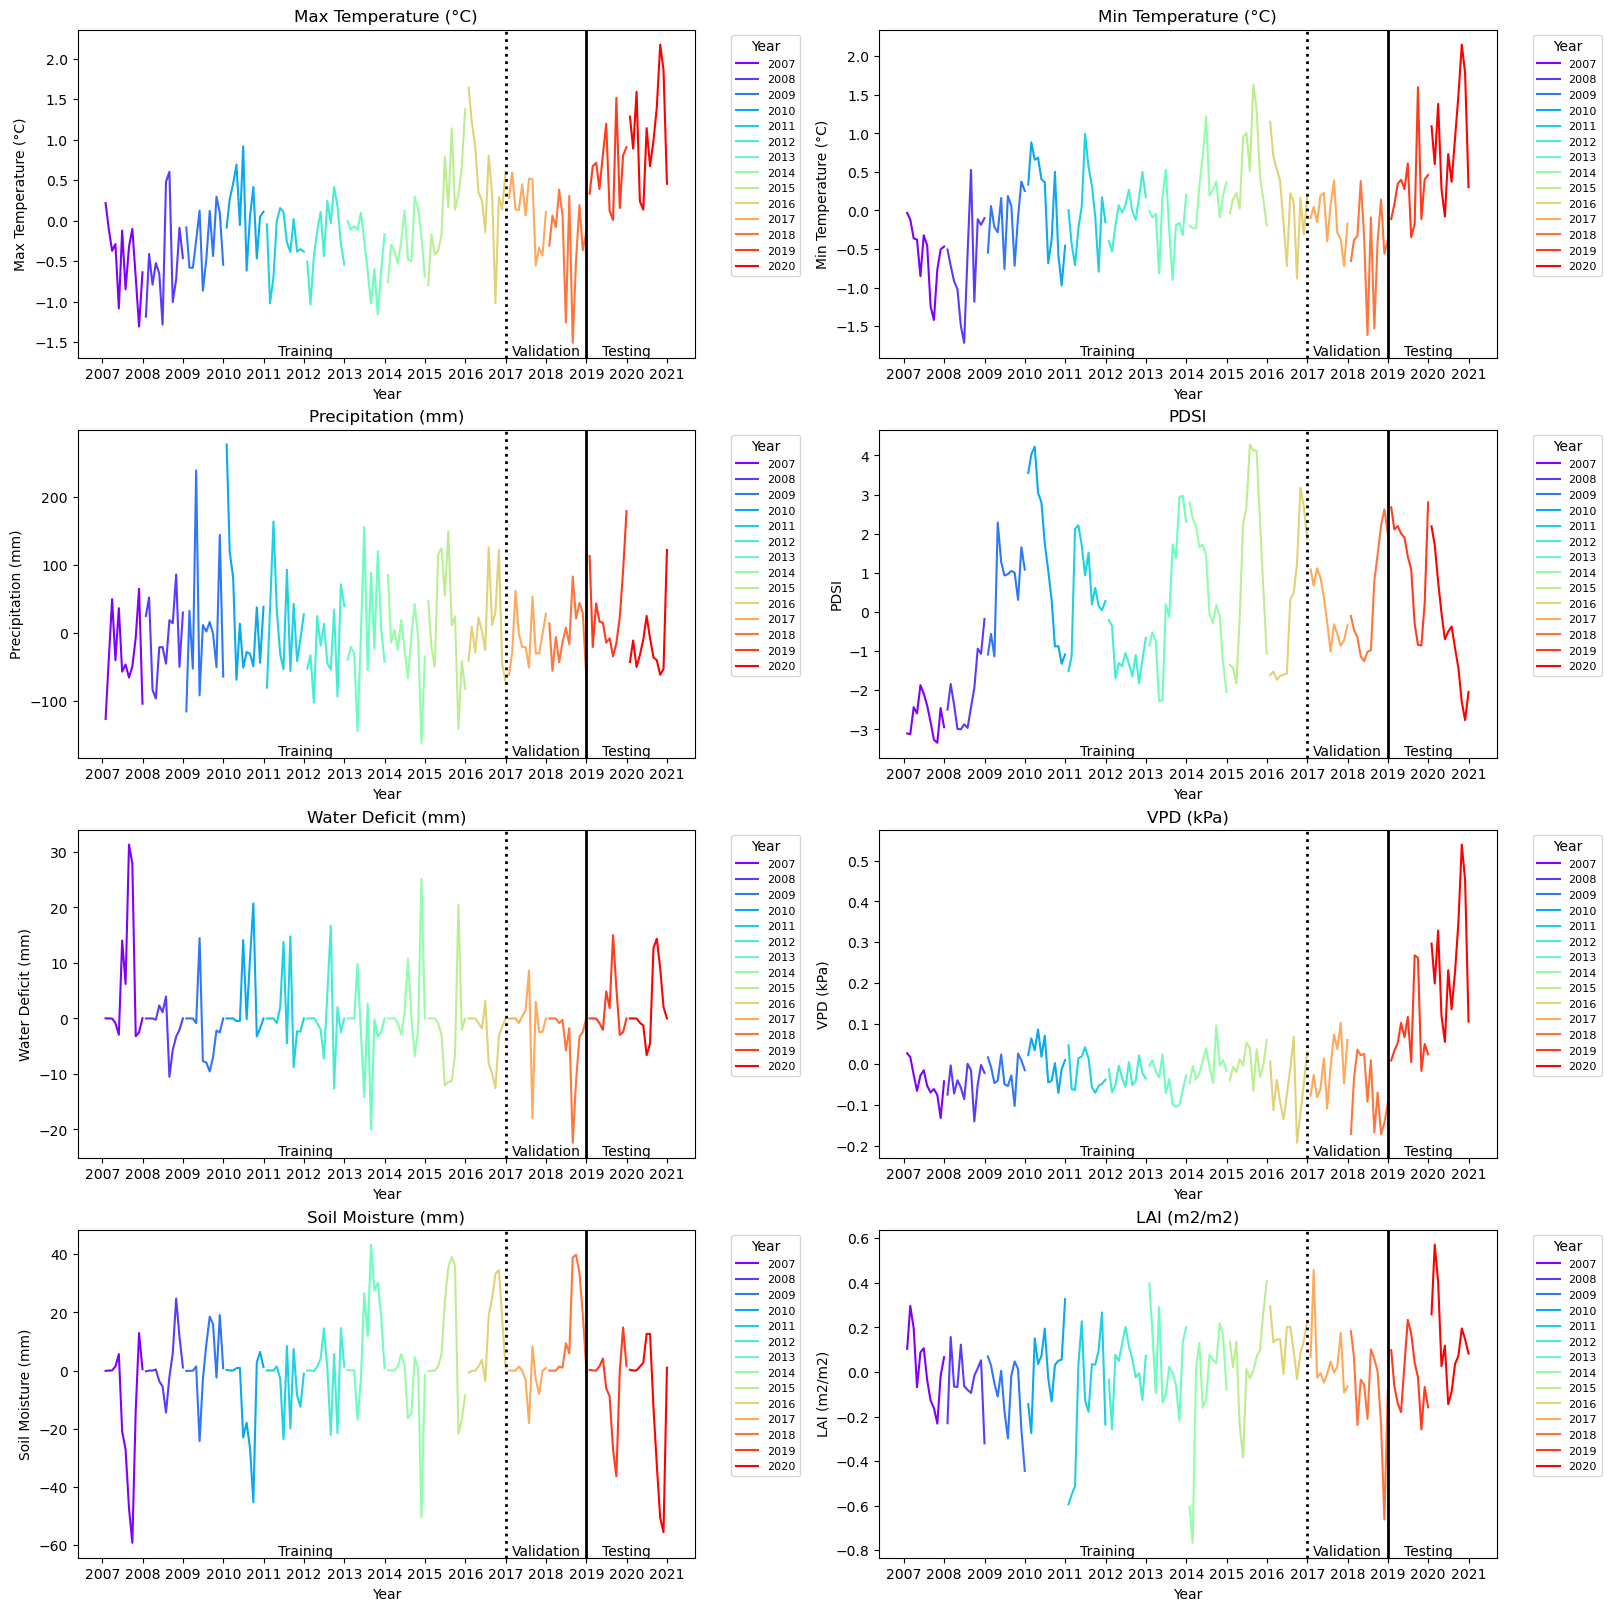

In [82]:
# Compute spatial mean
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# ---- Train / Val / Test split dates ----
val_split  = np.datetime64("2017-01-01")  # dotted
test_split = np.datetime64("2019-01-01")  # solid

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, nrows * 4),
    constrained_layout=True
)
axes = axes.flatten()

for idx, var in enumerate(spatialMean_xr.data_vars):
    ax = axes[idx]

    years = np.unique(spatialMean_xr[var].time.dt.year.values)
    colors = cm.rainbow(np.linspace(0, 1, len(years)))

    for i, (year, group) in enumerate(spatialMean_xr[var].groupby("year")):
        group.plot(ax=ax, label=str(year), color=colors[i])

    pretty = pretty_names.get(var, var)
    ax.set_title(pretty)
    ax.set_ylabel(pretty)
    ax.set_xlabel("Year")

    # ---- Force yearly ticks ----
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # ---- Vertical split lines ----
    ax.axvline(val_split,  color="black", linestyle=":", linewidth=2)
    ax.axvline(test_split, color="black", linestyle="-", linewidth=2)

    # ---- Section label positions ----
    tmin = spatialMean_xr.time.min().values
    tmax = spatialMean_xr.time.max().values

    train_mid = tmin + (val_split - tmin) / 2
    val_mid   = val_split + (test_split - val_split) / 2
    test_mid  = test_split + (tmax - test_split) / 2

    y0, y1 = ax.get_ylim()
    y_pos = y0 + 0.04 * (y1 - y0)

    ax.text(train_mid, y_pos, "Training",
            ha="center", va="top", fontsize=10, )

    ax.text(val_mid, y_pos, "Validation",
            ha="center", va="top", fontsize=10, )

    ax.text(test_mid, y_pos, "Testing",
            ha="center", va="top", fontsize=10, )

    # Legend outside
    ax.legend(
        title="Year",
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

# Remove empty subplots
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes[j])

# Save
# plt.savefig(
#     "/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varRaw_timeSeriesFull_clip0720.png",
#     dpi=300,
#     bbox_inches="tight"
# )
plt.show()

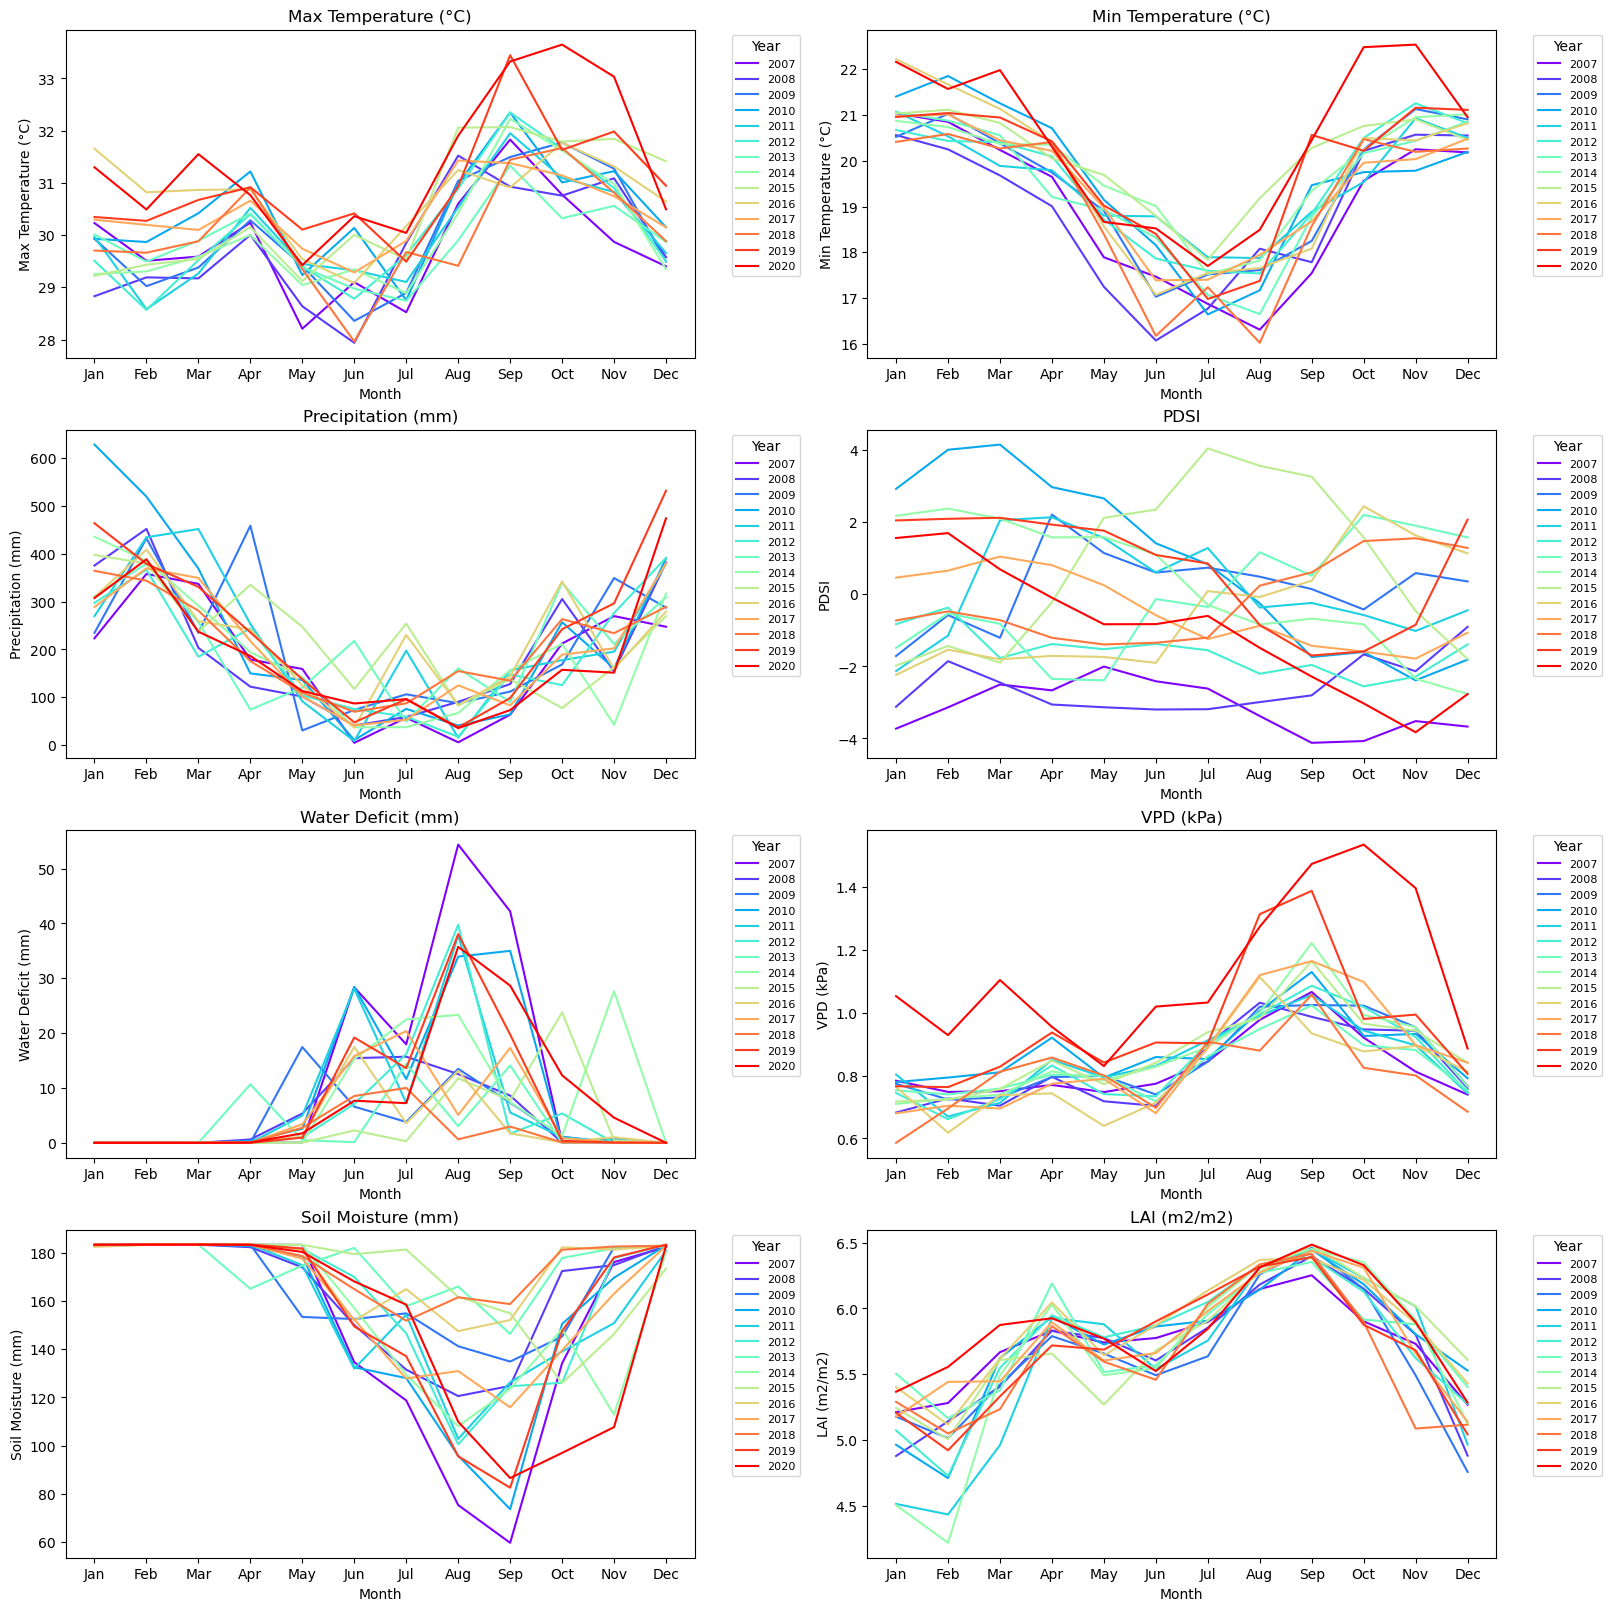

In [31]:
# Compute spatial mean
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, nrows * 4),
    constrained_layout=True
)
axes = axes.flatten()

for idx, var in enumerate(spatialMean_xr.data_vars):
    ax = axes[idx]

    years = np.unique(spatialMean_xr[var].year.values)
    colors = cm.rainbow(np.linspace(0, 1, len(years)))

    # ---- Plot each year as Jan–Dec on same axis ----
    for i, year in enumerate(years):
        yearly = spatialMean_xr[var].sel(time=spatialMean_xr.year == year)
        monthly = yearly.groupby("month").mean()

        ax.plot(
            monthly["month"],
            monthly.values,
            color=colors[i],
            label=str(year)
        )

    pretty = pretty_names.get(var, var)
    ax.set_title(pretty)
    ax.set_ylabel(pretty)
    ax.set_xlabel("Month")

    # ---- Month ticks & labels ----
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(
        ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
         "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    )

    # Legend outside (unchanged)
    ax.legend(
        title="Year",
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

# Remove empty subplots
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes[j])

# Save
plt.savefig(
    "/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varRaw_monthlyOverlay_clip0720.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [32]:
# spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

# # Assign 'year' and 'month' as coordinates (for plotting convenience)
# spatialMean_xr = spatialMean_xr.assign_coords(
#     year=spatialMean_xr.time.dt.year,
#     month=spatialMean_xr.time.dt.month
# )

# # Determine grid size
# num_vars = len(spatialMean_xr.data_vars)
# ncols = 2  # number of columns in grid
# nrows = int(np.ceil(num_vars / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows*4))
# axes = axes.flatten()  # flatten in case of single row/column

# # Loop over variables
# for ax, var in zip(axes, spatialMean_xr.data_vars):
#     for i, (year, group) in enumerate(spatialMean_xr[var].groupby("year")):
#         monthly = group.groupby("month").mean("time")
#         ax.plot(monthly.month, monthly, color=cmap(i), label=str(year))
    
#     ax.set_xlabel("Month")
#     ax.set_ylabel(var)
#     ax.set_title(f"{var} - raw by year")
#     ax.set_xticks(range(1,13))
#     ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# # Remove empty axes if any
# for j in range(len(spatialMean_xr.data_vars), len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.savefig("/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varRaw_monthOverlay_clip0720.png", dpi=300, bbox_inches='tight')
# plt.show()

# Calculate Anomalies

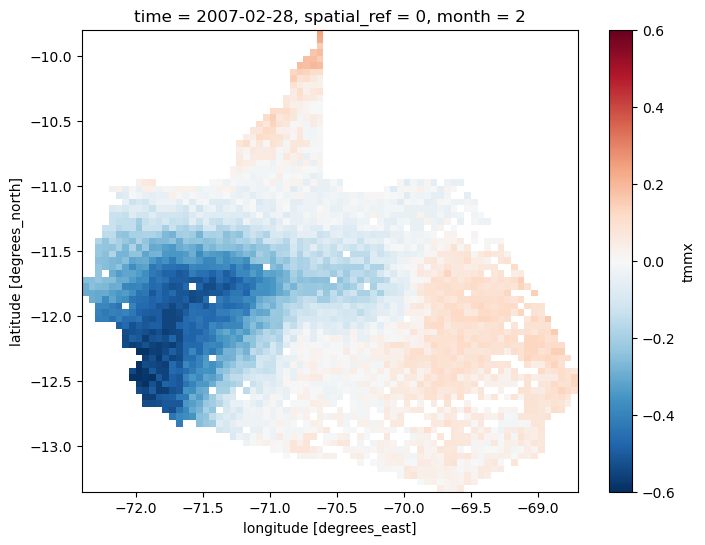

In [76]:
# Calculate monthly climatology for the whole dataset
monthlyMean_xr = combo_xr.groupby("time.month").mean("time")

# Subtract climatology to get seasonal anomalies
combo_deseason_xr = combo_xr.groupby("time.month") - monthlyMean_xr

# plot
combo_deseason_xr.tmmx.isel(time=1).plot(figsize=(8,6))


## Export

In [77]:
# Export to a netCDF (optional)
# output_path = "/home/jovyan/large_files/climLai_masked_anom.nc"
# combo_deseason_xr.to_netcdf(output_path)

In [78]:
combo_xr = combo_deseason_xr

# Visualize

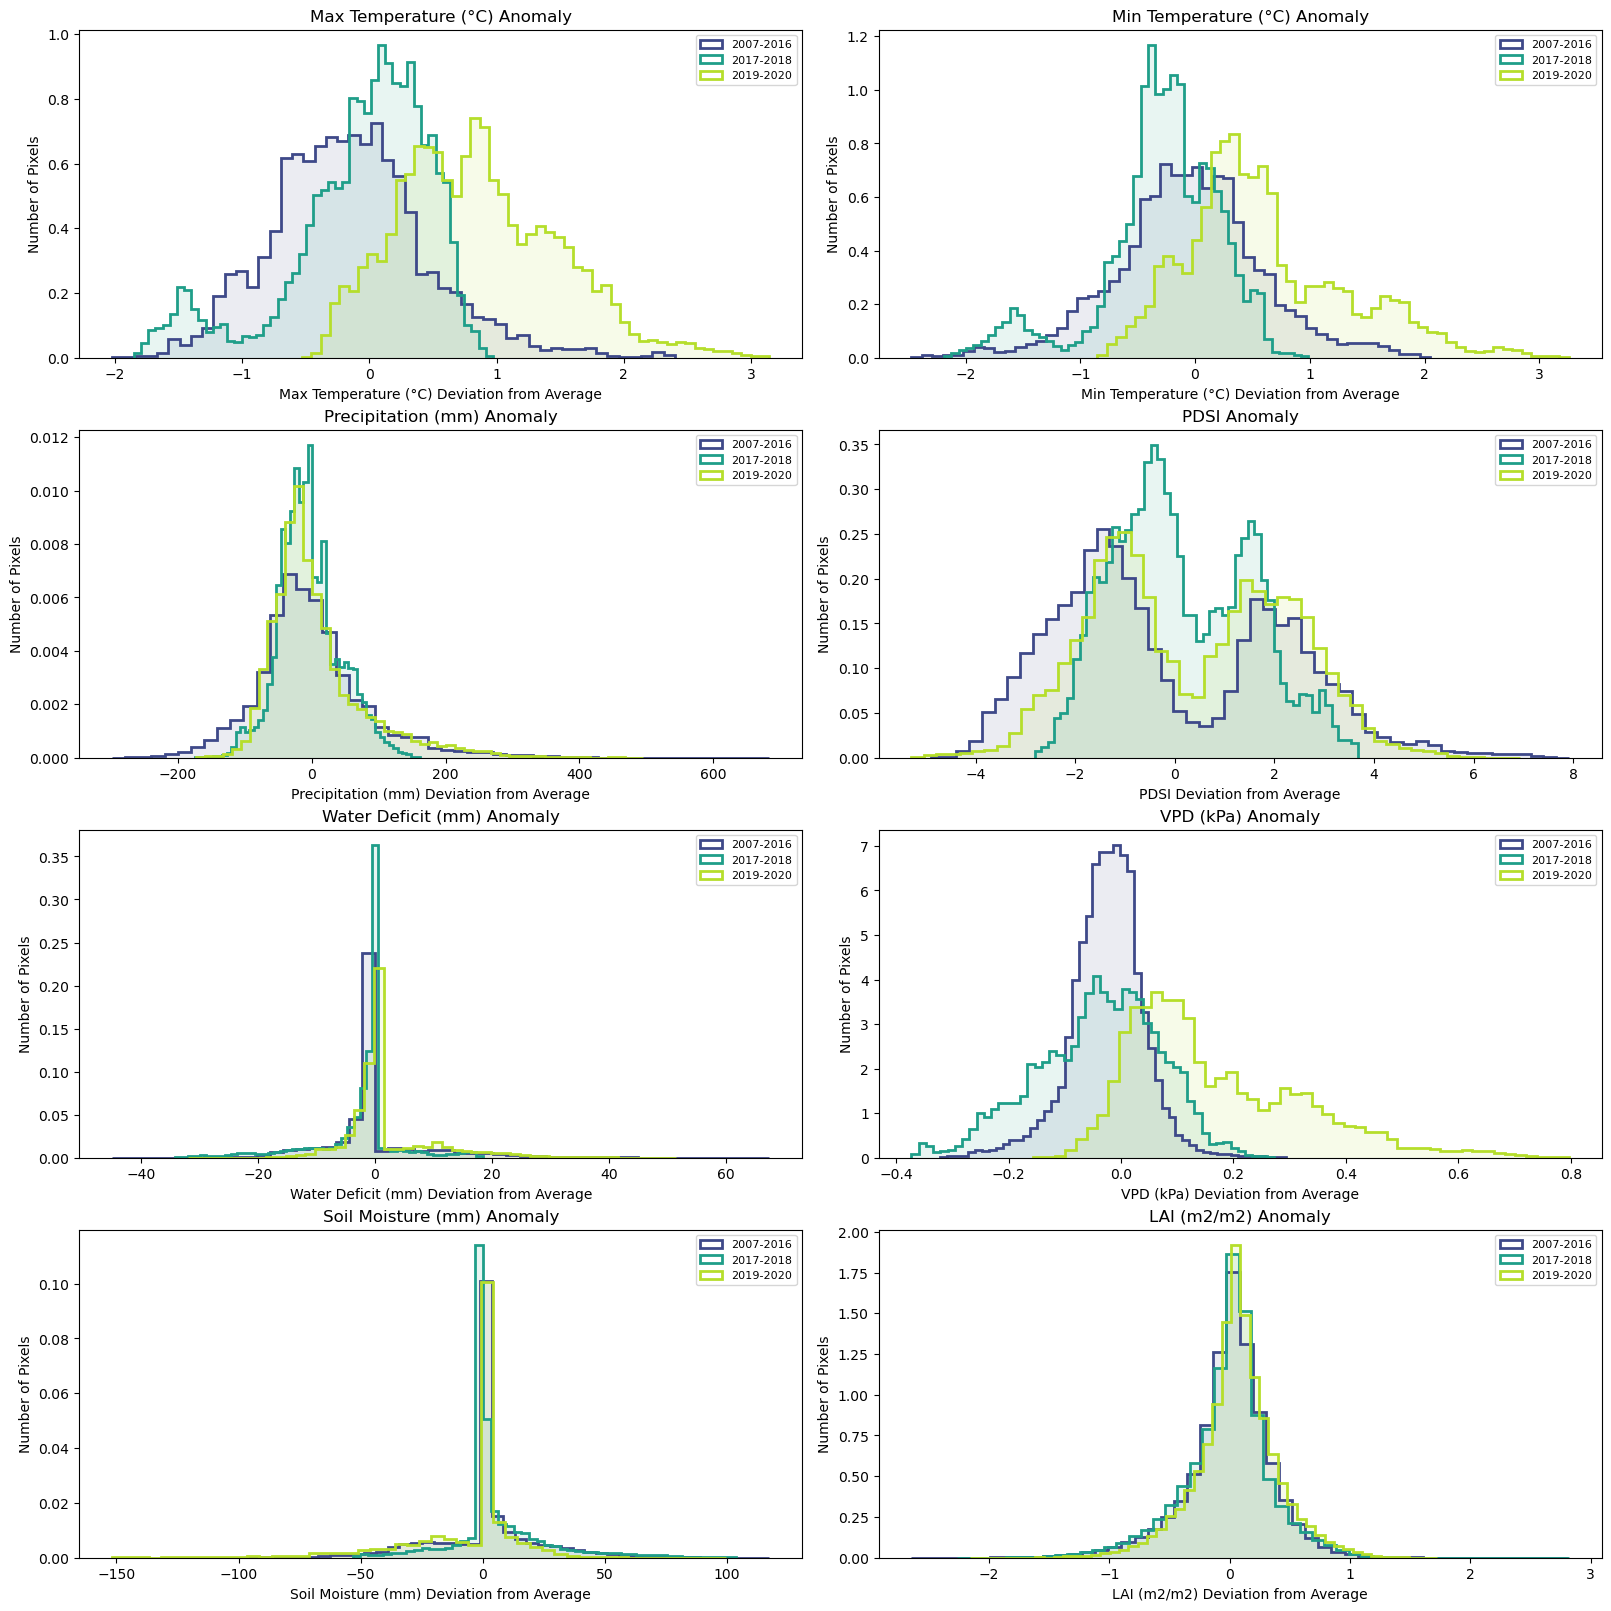

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Define your time slices ----
slices = {
    "2007-2016": slice("2007-01-01", "2016-12-31"),
    "2017-2018": slice("2017-01-01", "2018-12-31"),
    "2019-2020": slice("2019-01-01", "2020-12-31"),
}
colors = ["#3e4989", "#1f9e89", "#b5de2b"]  # hex colors
alpha_fill = 0.1  # very light fill
linewidth = 2     # outline thickness

# Determine grid layout
num_vars = len(combo_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, nrows * 4),
    constrained_layout=True
)
axes = axes.flatten()

for idx, var in enumerate(combo_xr.data_vars):
    ax = axes[idx]
    
    for color, (label, time_slice) in zip(colors, slices.items()):
        # select the time slice and flatten to 1D
        data_slice = combo_xr[var].sel(time=time_slice).values.flatten()
        data_slice = data_slice[~np.isnan(data_slice)]
        
        # Draw filled histogram first (very light)
        ax.hist(
            data_slice,
            bins=50,
            color=color,
            alpha=alpha_fill,
            density=True,
            histtype='stepfilled',
            linewidth=0
        )
        
        # Draw outline on top
        ax.hist(
            data_slice,
            bins=50,
            color=color,
            density=True,
            histtype='step',
            linewidth=linewidth,
            label=label
        )

    pretty = pretty_names.get(var, var)
    ax.set_title(f"{pretty} Anomaly")
    ax.set_xlabel(f"{pretty} Deviation from Average")        # <-- use pretty name here
    ax.set_ylabel("Number of Pixels")
    ax.legend(fontsize=8)

# Remove empty subplots
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.show()


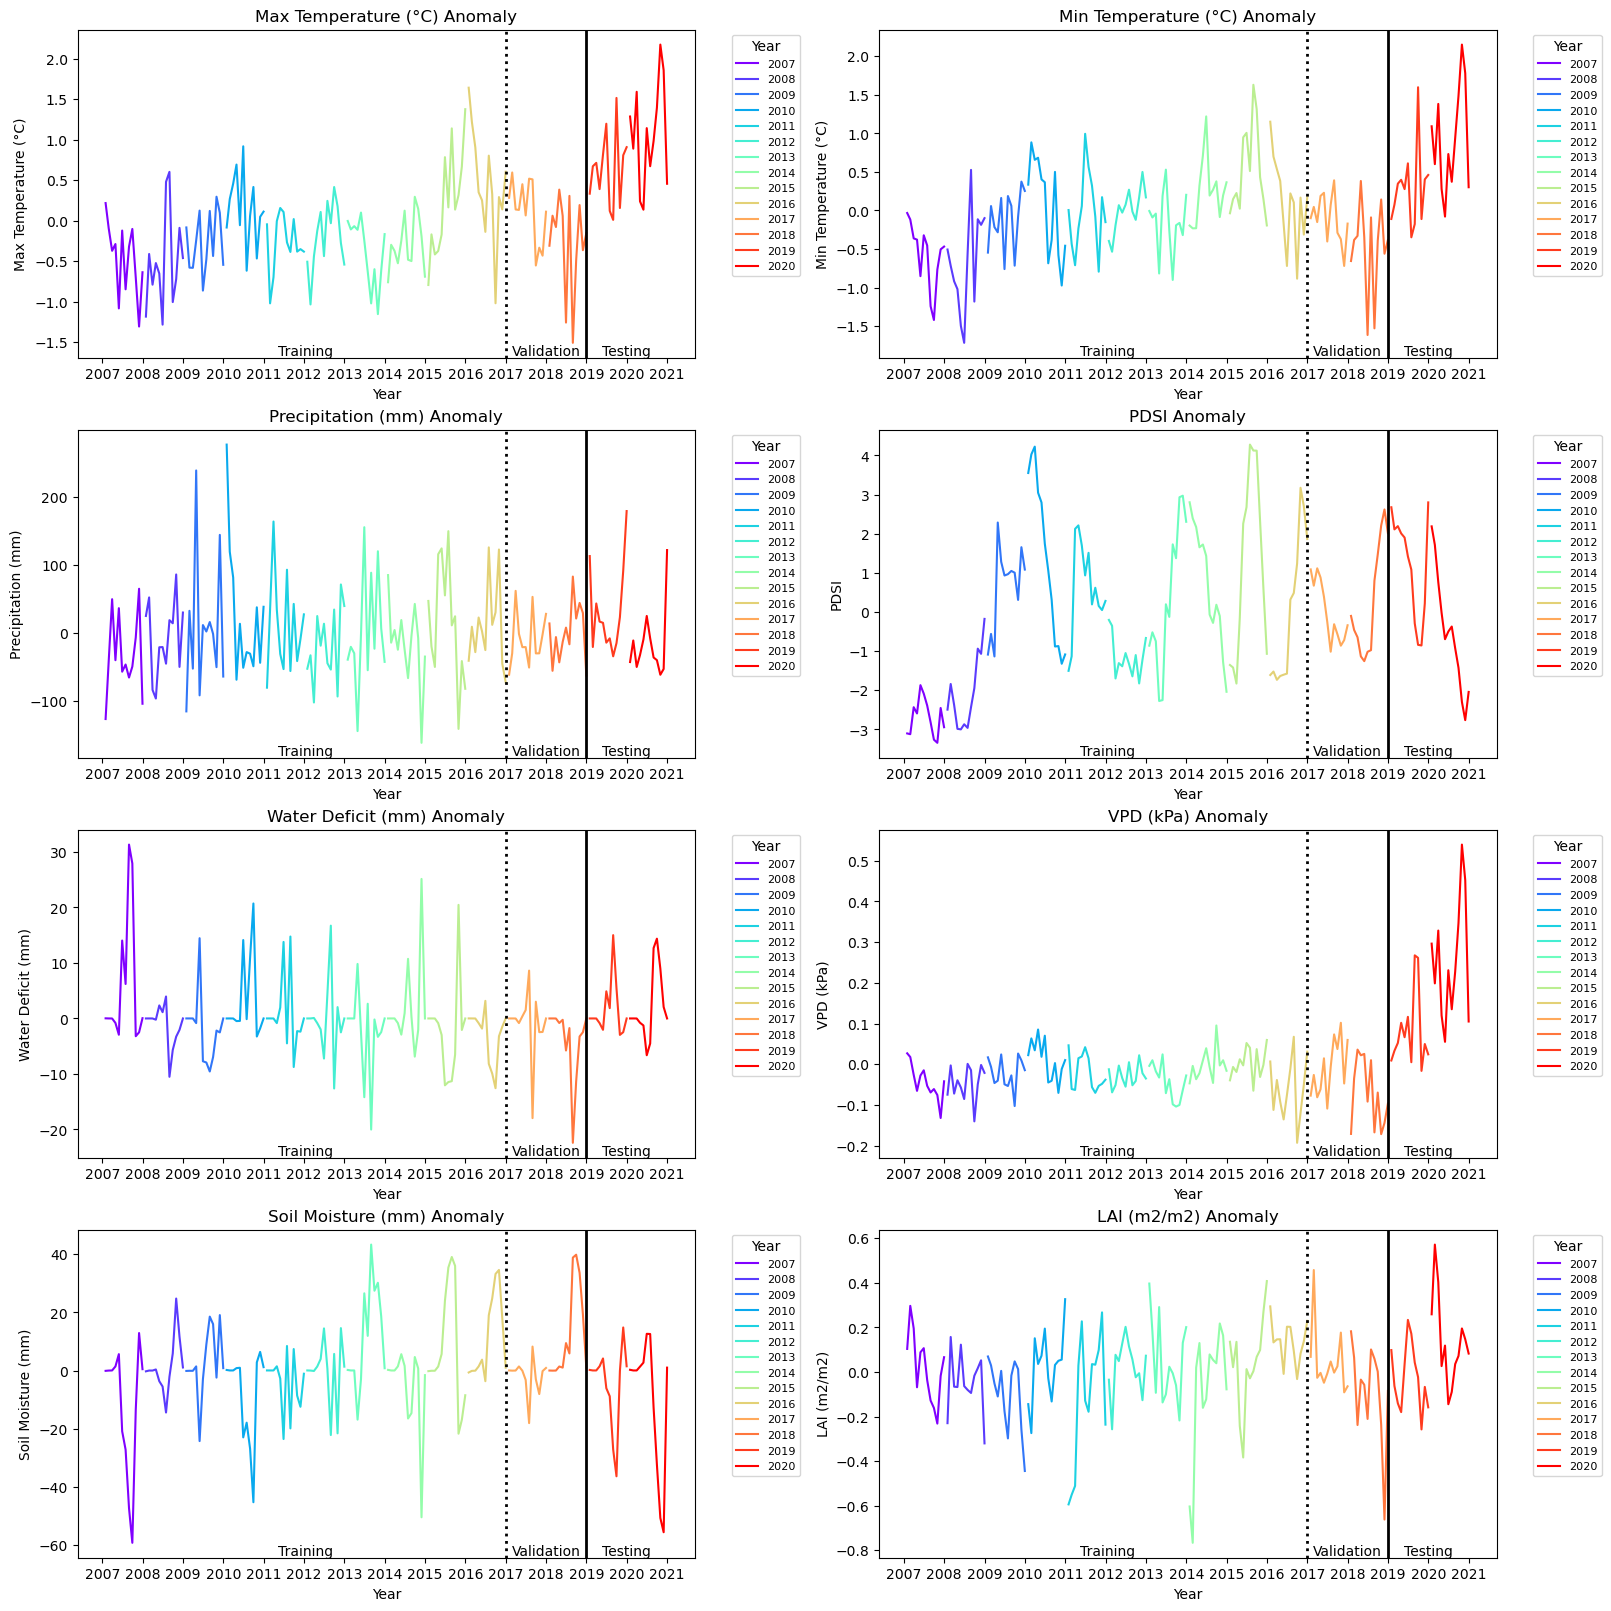

In [37]:


# Compute spatial mean
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# ---- Train / Val / Test split dates ----
val_split  = np.datetime64("2017-01-01")  # dotted
test_split = np.datetime64("2019-01-01")  # solid

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, nrows * 4),
    constrained_layout=True
)
axes = axes.flatten()

for idx, var in enumerate(spatialMean_xr.data_vars):
    ax = axes[idx]

    years = np.unique(spatialMean_xr[var].time.dt.year.values)
    colors = cm.rainbow(np.linspace(0, 1, len(years)))

    for i, (year, group) in enumerate(spatialMean_xr[var].groupby("year")):
        group.plot(ax=ax, label=str(year), color=colors[i])

    pretty = pretty_names.get(var, var)
    ax.set_title(f"{pretty} Anomaly")
    ax.set_ylabel(pretty)
    ax.set_xlabel("Year")

    # ---- Force yearly ticks ----
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # ---- Vertical split lines ----
    ax.axvline(val_split,  color="black", linestyle=":", linewidth=2)
    ax.axvline(test_split, color="black", linestyle="-", linewidth=2)

    # ---- Section label positions ----
    tmin = spatialMean_xr.time.min().values
    tmax = spatialMean_xr.time.max().values

    train_mid = tmin + (val_split - tmin) / 2
    val_mid   = val_split + (test_split - val_split) / 2
    test_mid  = test_split + (tmax - test_split) / 2

    y0, y1 = ax.get_ylim()
    y_pos = y0 + 0.04 * (y1 - y0)

    ax.text(train_mid, y_pos, "Training",
            ha="center", va="top", fontsize=10, )

    ax.text(val_mid, y_pos, "Validation",
            ha="center", va="top", fontsize=10, )

    ax.text(test_mid, y_pos, "Testing",
            ha="center", va="top", fontsize=10, )

    # Legend outside
    ax.legend(
        title="Year",
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

# Remove empty subplots
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes[j])

# Save
plt.savefig(
    "/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varAnom_timeSeriesFull_clip0720.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

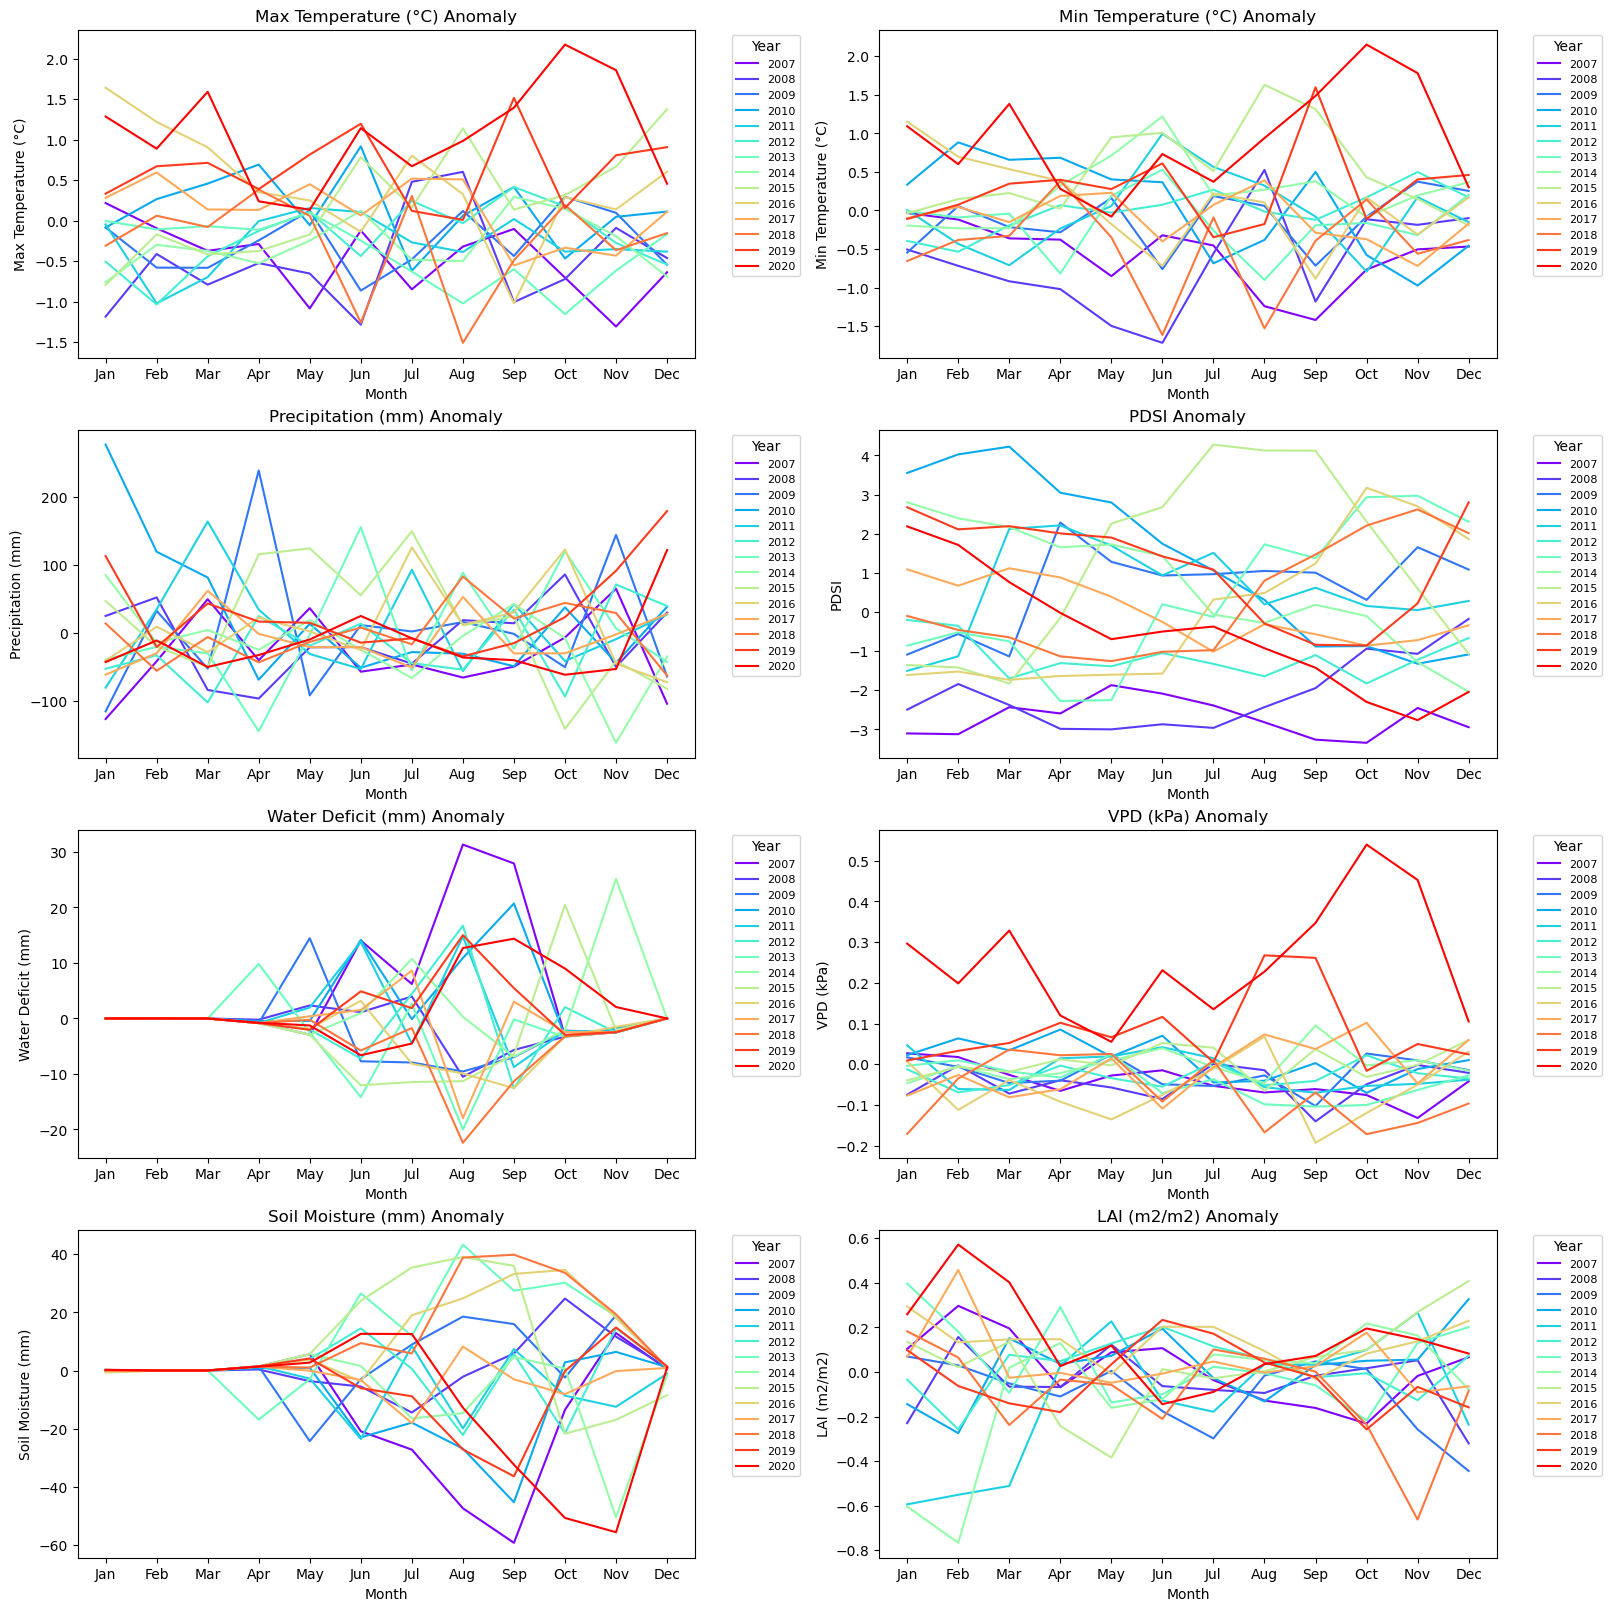

In [39]:
# Compute spatial mean
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, nrows * 4),
    constrained_layout=True
)
axes = axes.flatten()

for idx, var in enumerate(spatialMean_xr.data_vars):
    ax = axes[idx]

    years = np.unique(spatialMean_xr[var].year.values)
    colors = cm.rainbow(np.linspace(0, 1, len(years)))

    # ---- Plot each year as Jan–Dec on same axis ----
    for i, year in enumerate(years):
        yearly = spatialMean_xr[var].sel(time=spatialMean_xr.year == year)
        monthly = yearly.groupby("month").mean()

        ax.plot(
            monthly["month"],
            monthly.values,
            color=colors[i],
            label=str(year)
        )

    pretty = pretty_names.get(var, var)
    ax.set_title(f"{pretty} Anomaly")
    ax.set_ylabel(pretty)
    ax.set_xlabel("Month")

    # ---- Month ticks & labels ----
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(
        ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
         "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    )

    # Legend outside (unchanged)
    ax.legend(
        title="Year",
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

# Remove empty subplots
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes[j])

# Save
plt.savefig(
    "/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varAnom_monthlyOverlay_clip0720.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [38]:
# spatialMean_xr = combo_deseason_xr.mean(dim=["lat", "lon"])

# # Assign 'year' and 'month' as coordinates (for plotting convenience)
# spatialMean_xr = spatialMean_xr.assign_coords(
#     year=spatialMean_xr.time.dt.year,
#     month=spatialMean_xr.time.dt.month
# )

# # Determine grid size
# num_vars = len(spatialMean_xr.data_vars)
# ncols = 2  # number of columns in grid
# nrows = int(np.ceil(num_vars / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows*4))
# axes = axes.flatten()  # flatten in case of single row/column

# # Loop over variables
# for ax, var in zip(axes, spatialMean_xr.data_vars):
#     for i, (year, group) in enumerate(spatialMean_xr[var].groupby("year")):
#         monthly = group.groupby("month").mean("time")
#         ax.plot(monthly.month, monthly, color=cmap(i), label=str(year))
    
#     ax.set_xlabel("Month")
#     ax.set_ylabel(var)
#     ax.set_title(f"{var} - anomalies by year")
#     ax.set_xticks(range(1,13))
#     ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# # Remove empty axes if any
# for j in range(len(spatialMean_xr.data_vars), len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.savefig("/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varAnom_monthOverlay_clip0720.png", dpi=300, bbox_inches='tight')
# plt.show()